In [1]:
import syft as sy
import copy
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
#Determine if there is a GPU
train_on_gpu = torch.cuda.is_available()
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
PATH_train="./train"
PATH_val="./val"
PATH_test="./test"

In [4]:
TRAIN =Path(PATH_train)
VALID = Path(PATH_val)
TEST=Path(PATH_test)
print(TRAIN)
print(VALID)
print(TEST)

train
val
test


In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# learning rate
LR = 0.001

In [6]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [7]:
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)


In [8]:
test_data

Dataset ImageFolder
    Number of datapoints: 1622
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
print(train_data.class_to_idx)
print(valid_data.class_to_idx)
print(test_data.class_to_idx)

{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}


In [10]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [11]:
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 3, 50, 50]), torch.Size([32]))

In [12]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,220,220) 48
        #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2) 16 24 24
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(32,106,106) 20 20
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=1) #output_shape=(32,53,53) 10 10
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=0) #output_shape=(16,51,51) 10 10
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=1) #output_shape=(16,25,25) 5 5
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, stride=1, padding=0) #output_shape=(8,23,23) 5 5
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11) 8 5 5
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        #self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 2) 
        #self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        #out = self.output(out)

        return out

In [13]:
model = CNN_Model()
from torchsummary import summary
summary(model.cuda(), (3, 50, 50))
#summary(model, (3, 50, 50),device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 22, 22]           4,640
              ReLU-5           [-1, 32, 22, 22]               0
         MaxPool2d-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 16, 22, 22]             528
              ReLU-8           [-1, 16, 22, 22]               0
         MaxPool2d-9           [-1, 16, 22, 22]               0
           Conv2d-10            [-1, 8, 22, 22]             136
             ReLU-11            [-1, 8, 22, 22]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Linear-13                  [-1, 512]         496,128
           Linear-14                   

In [14]:
print(model.state_dict())

OrderedDict([('cnn1.weight', tensor([[[[ 0.0411, -0.1519,  0.0293],
          [ 0.1263, -0.0078,  0.1380],
          [ 0.0303,  0.1390, -0.1592]],

         [[-0.1040,  0.1615,  0.1818],
          [ 0.1734,  0.0125, -0.0990],
          [ 0.1316,  0.0521,  0.0518]],

         [[ 0.1318, -0.0597,  0.0483],
          [ 0.1484,  0.0926,  0.0705],
          [-0.1868, -0.0953,  0.1791]]],


        [[[-0.1017, -0.0304,  0.1486],
          [ 0.0547, -0.0286,  0.1921],
          [-0.1132,  0.1203, -0.0821]],

         [[ 0.1098,  0.0393, -0.0089],
          [-0.1621,  0.0509,  0.0149],
          [ 0.0362, -0.1869, -0.0803]],

         [[-0.1011, -0.0668,  0.0367],
          [ 0.0799,  0.0781, -0.0018],
          [-0.1233, -0.1811,  0.0601]]],


        [[[ 0.1788,  0.1287, -0.0154],
          [-0.0735, -0.1038, -0.0290],
          [ 0.0978,  0.0776, -0.1326]],

         [[ 0.0474, -0.1770,  0.0701],
          [-0.1811, -0.1347,  0.1520],
          [ 0.0479,  0.0343,  0.0829]],

         [[ 0.1

In [15]:
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

In [16]:
import torch.optim as optim    
optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
criterion = nn.CrossEntropyLoss() 

running epoch: 1



	Training Loss: 0.407968 	Validation Loss: 0.403960
Validation loss decreased (inf --> 0.403960).  Saving model ...
[0.4079675765391005]
[0.4039597001986588]


/home/leo6532/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


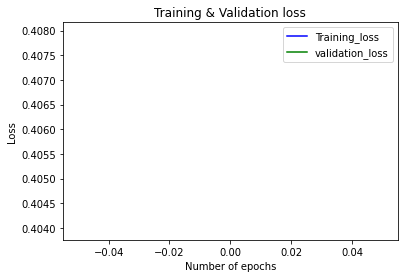

In [17]:
if train_on_gpu:
    model.cuda()
# number of epochs to train the model
n_epochs = 1 #170


valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]

train_loss_i = [] 
valid_loss_i = []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        with torch.no_grad():
            output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    #作圖接收矩陣
    train_loss_i.append(train_loss)
    valid_loss_i.append(valid_loss)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_CNN.pth')
        torch.save(model, "o_model.pth")
        valid_loss_min = valid_loss
#作圖區
print(train_loss_i) 
print(valid_loss_i)

plt.plot(range(n_epochs), train_loss_i,'b-', label='Training_loss')
plt.plot(range(n_epochs), valid_loss_i,'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
print(model.state_dict())

OrderedDict([('cnn1.weight', tensor([[[[ 4.3631e-02, -1.4934e-01,  3.0487e-02],
          [ 1.3620e-01, -8.7945e-04,  1.4578e-01],
          [ 4.6119e-02,  1.5437e-01, -1.4302e-01]],

         [[-9.7464e-02,  1.6773e-01,  1.8670e-01],
          [ 1.8652e-01,  2.2554e-02, -8.8016e-02],
          [ 1.5032e-01,  7.0171e-02,  7.0772e-02]],

         [[ 1.4363e-01, -4.8580e-02,  5.8282e-02],
          [ 1.6558e-01,  1.0677e-01,  8.5537e-02],
          [-1.6444e-01, -7.3739e-02,  2.0141e-01]]],


        [[[-8.5975e-02, -1.3932e-02,  1.6522e-01],
          [ 7.0449e-02, -1.3199e-02,  2.0559e-01],
          [-9.9543e-02,  1.3346e-01, -7.1039e-02]],

         [[ 1.2586e-01,  5.6154e-02,  8.0827e-03],
          [-1.4597e-01,  6.6565e-02,  2.8507e-02],
          [ 5.0013e-02, -1.7375e-01, -6.9327e-02]],

         [[-8.4501e-02, -4.9251e-02,  5.4388e-02],
          [ 9.6579e-02,  9.4361e-02,  1.1827e-02],
          [-1.0936e-01, -1.6782e-01,  7.0798e-02]]],


        [[[ 1.8551e-01,  1.3399e-01, 

#TEST MODEL

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [20]:
use_cuda = torch.cuda.is_available()
model.cuda()
test(test_loader, model, criterion, use_cuda)

Test Loss: 0.391213
Test Accuracy: 82% (1342/1622)


In [21]:
model_1 = torch.load('model_CNN.pth')

# 虛擬環境執行 model

In [22]:
import copy

In [23]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
server = sy.VirtualWorker(hook, id="server")
compute_nodes = [bob, alice]


In [24]:
# Create CNN Model
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,220,220) 48
        #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2) 16 24 24
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(32,106,106) 20 20
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=1) #output_shape=(32,53,53) 10 10
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=0) #output_shape=(16,51,51) 10 10
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=1) #output_shape=(16,25,25) 5 5
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, stride=1, padding=0) #output_shape=(8,23,23) 5 5
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11) 8 5 5
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        #self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 2) 
        #self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        #out = self.output(out)

        return out

In [25]:
new_model = CNN_Model2().cuda()

In [26]:
optimizer = torch.optim.Adam(new_model.parameters(), lr=LR) 
criterion = nn.CrossEntropyLoss() 

In [27]:
bobs_data = data.copy().send(bob).cuda()
bobs_target = target.copy().send(bob).cuda()
alices_data = data.copy().send(alice).cuda()
alices_target = target.copy().send(alice).cuda()

In [28]:
bobs_model = new_model
alices_model = new_model

# 一定要把model get回來才能使用

In [29]:
bobs_data.get()
alices_data.get()

tensor([[[[ 1.3413,  1.2557,  1.2385,  ...,  0.9132,  0.8789,  0.9132],
          [ 1.3413,  1.2728,  1.2728,  ...,  0.8789,  0.9474,  0.9817],
          [ 1.3070,  1.2728,  1.2728,  ...,  0.9303,  0.9646,  0.9988],
          ...,
          [-1.2445, -0.9877, -0.4054,  ...,  0.9303,  0.9303,  0.9474],
          [-1.4329, -1.1932, -0.6623,  ...,  0.8961,  0.9303,  0.9132],
          [-1.6384, -1.5870, -1.2959,  ...,  0.8789,  0.9303,  0.9303]],

         [[ 1.5007,  1.4132,  1.3957,  ...,  1.0630,  1.0280,  1.0630],
          [ 1.5007,  1.4307,  1.4307,  ...,  1.0280,  1.0980,  1.1331],
          [ 1.4657,  1.4307,  1.4307,  ...,  1.0805,  1.1155,  1.1506],
          ...,
          [-1.1429, -0.8803, -0.2850,  ...,  1.0805,  1.0805,  1.0980],
          [-1.3354, -1.0903, -0.5476,  ...,  1.0455,  1.0805,  1.0630],
          [-1.5455, -1.4930, -1.1954,  ...,  1.0280,  1.0805,  1.0805]],

         [[ 1.7163,  1.6291,  1.6117,  ...,  1.2805,  1.2457,  1.2805],
          [ 1.7163,  1.6465,  

In [30]:
bobs_target.get()
alices_target.get()

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

### get一次就好 第2次會error

In [31]:
#bobs_model.get()

In [32]:
#alices_model.get()

# bob's model training 

running epoch: 1



	Training Loss: 0.413249 	Validation Loss: 0.364508
Validation loss decreased (inf --> 0.364508).  Saving model ...
[0.4132491113341151]
[0.3645076664852563]


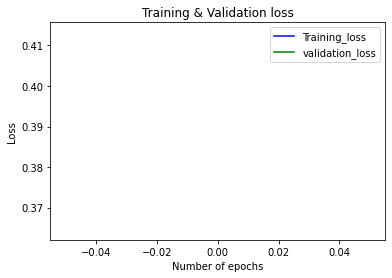

In [33]:
# number of epochs to train the model
bobs_train_loss_i = []
bobs_valid_loss_i = []


n_epochs = 150 #170


bobs_valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    bobs_train_loss = 0.0
    bobs_valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    bobs_model.train()
    for bobs_data, bobs_target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            bobs_data, bobs_target = bobs_data.cuda(),  bobs_target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = bobs_model(bobs_data)
        # calculate the batch loss
        loss = criterion(output,bobs_target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        bobs_train_loss += loss.item()*bobs_data.size(0)

        
    for bobs_data, bobs_target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            bobs_data, bobs_target = bobs_data.cuda(), bobs_target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        with torch.no_grad():
            output = bobs_model(bobs_data)
        # calculate the batch loss
        loss = criterion(output,bobs_target)
        # update average validation loss 
        bobs_valid_loss += loss.item()* bobs_data.size(0)   
        
        
    bobs_train_loss = bobs_train_loss/len(train_loader.dataset)    
    bobs_valid_loss = bobs_valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
         bobs_train_loss,  bobs_valid_loss))    
    #作圖接收矩陣
    bobs_train_loss_i.append(bobs_train_loss)
    bobs_valid_loss_i.append(bobs_valid_loss)
    if bobs_valid_loss <= bobs_valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        bobs_valid_loss_min,
        bobs_valid_loss))
        bobs_valid_loss_min = bobs_valid_loss
#作圖區
print(bobs_train_loss_i) 
print(bobs_valid_loss_i)    
    
#圖區    
plt.plot(range(n_epochs), bobs_train_loss_i,'b-', label='Training_loss')
plt.plot(range(n_epochs), bobs_valid_loss_i,'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()    

In [34]:
test(test_loader, bobs_model, criterion, use_cuda)
test(test_loader, alices_model, criterion, use_cuda)
#test(test_loader, model1, criterion, use_cuda)

Test Loss: 0.351283
Test Accuracy: 85% (1381/1622)
Test Loss: 0.351283
Test Accuracy: 85% (1381/1622)


# Node gradient send to server

In [35]:
bobS_gradient = bobs_model.copy().send(server)
alices_gardient = alices_model.copy().send(server)

In [36]:
bobS_gradient.get()
alices_gardient.get()

CNN_Model2(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=968, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

# Use update gradient

In [37]:
#模型的層數
num_layers = len(list(bobs_model.parameters()))
#模型權重平均運算
new_list = list(map(lambda x,y: x + y, list(bobs_model.parameters()), list(bobs_model.parameters())))
p = list(model.parameters())
print(list(model.parameters()))
print(123)

with torch.no_grad():
    for i in range(num_layers):
        p[i].set_(new_list[i])

print(list(model.parameters()))

[Parameter containing:
tensor([[[[ 4.3631e-02, -1.4934e-01,  3.0487e-02],
          [ 1.3620e-01, -8.7945e-04,  1.4578e-01],
          [ 4.6119e-02,  1.5437e-01, -1.4302e-01]],

         [[-9.7464e-02,  1.6773e-01,  1.8670e-01],
          [ 1.8652e-01,  2.2554e-02, -8.8016e-02],
          [ 1.5032e-01,  7.0171e-02,  7.0772e-02]],

         [[ 1.4363e-01, -4.8580e-02,  5.8282e-02],
          [ 1.6558e-01,  1.0677e-01,  8.5537e-02],
          [-1.6444e-01, -7.3739e-02,  2.0141e-01]]],


        [[[-8.5975e-02, -1.3932e-02,  1.6522e-01],
          [ 7.0449e-02, -1.3199e-02,  2.0559e-01],
          [-9.9543e-02,  1.3346e-01, -7.1039e-02]],

         [[ 1.2586e-01,  5.6154e-02,  8.0827e-03],
          [-1.4597e-01,  6.6565e-02,  2.8507e-02],
          [ 5.0013e-02, -1.7375e-01, -6.9327e-02]],

         [[-8.4501e-02, -4.9251e-02,  5.4388e-02],
          [ 9.6579e-02,  9.4361e-02,  1.1827e-02],
          [-1.0936e-01, -1.6782e-01,  7.0798e-02]]],


        [[[ 1.8551e-01,  1.3399e-01, -9.204

[Parameter containing:
tensor([[[[-0.1283, -0.1933, -0.2767],
          [ 0.3537,  0.0489,  0.2934],
          [ 0.0899, -0.3423, -0.3517]],

         [[-0.3329, -0.2808,  0.1242],
          [-0.3232, -0.0019,  0.2211],
          [-0.0702, -0.3318, -0.3270]],

         [[ 0.1867, -0.2396, -0.1101],
          [-0.2081,  0.2469,  0.1123],
          [-0.2431,  0.2779, -0.3564]]],


        [[[ 0.0093, -0.1351, -0.2346],
          [-0.2610,  0.1387, -0.2568],
          [ 0.3335, -0.0204,  0.0514]],

         [[-0.0443,  0.0894, -0.1484],
          [-0.2531,  0.1929, -0.0247],
          [-0.2901, -0.3322,  0.0639]],

         [[-0.1936, -0.2634,  0.1761],
          [ 0.2563,  0.1899, -0.2442],
          [ 0.2932,  0.3348,  0.1239]]],


        [[[-0.2586,  0.1480, -0.0441],
          [ 0.2705, -0.0844, -0.0636],
          [-0.0225,  0.3081, -0.3151]],

         [[-0.2371,  0.0935, -0.3550],
          [-0.2158,  0.0426,  0.0848],
          [ 0.3793,  0.0617,  0.3796]],

         [[ 0.0242,  

In [38]:
a = [1, 2, 3]
b = [4,5,6]
new_list = map(lambda x,y: x + y, a,b)   
print(list(new_list))

[5, 7, 9]
